In [ ]:
import pysam
import matplotlib.pyplot as plt
import tinycov


ModuleNotFoundError: No module named 'pysam'

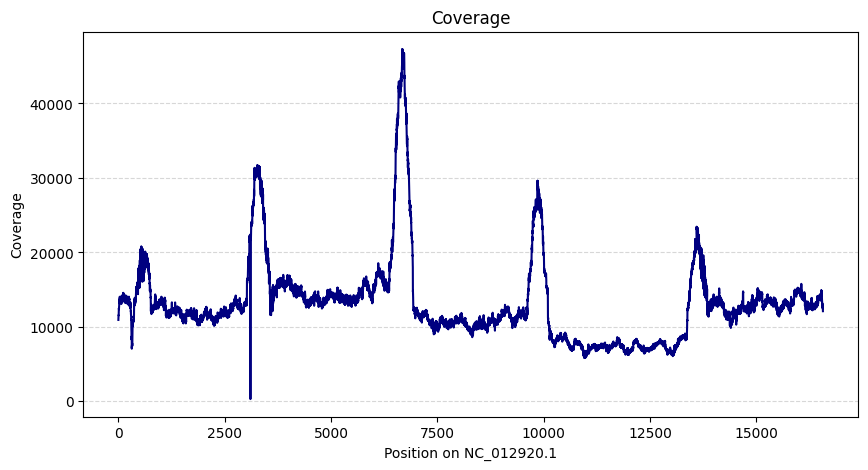

In [ ]:
#creating a coverage plot for a single BAM file
bam_path = "/mnt/claw-raid/elliot/3842_003_sorted.bam"
chrom = "NC_012920.1"  # mitochondrial genome

bam = pysam.AlignmentFile(bam_path, "rb")
mt_length = bam.get_reference_length(chrom)
coverage = [sum(x) for x in zip(*bam.count_coverage(chrom, start=0, end=mt_length))]
bam.close()

plt.figure(figsize=(10,5))
plt.plot(coverage, color="navy")
plt.title("Coverage")
plt.xlabel("Position on NC_012920.1")
plt.ylabel("Coverage")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [4]:
#  Imports & Configuration 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import glob

# --- Configuration ---
CONFIG = {
    'variant_pattern': "/mnt/claw-raid/elliot/variants.annotatedCell*.txt",
    'haplo_pattern': "/mnt/claw-raid/elliot/haplogroupsCell*.txt",
    'min_coverage': 500,
    'min_heteroplasmy': 5.0,
    'haplo_alt_allele_threshold'
    '': 95.0,  # Flip variants above this VAF
}

print("✅ Configuration loaded")


✅ Configuration loaded


In [ ]:
import pysam
import matplotlib.pyplot as plt
import glob
import os
import re

# Directory containing BAM files
bam_dir = "/mnt/claw-raid/elliot/P003"
chrom = "NC_012920.1"  # mitochondrial genome

# Find all sorted BAM files matching the pattern
bam_files = sorted(glob.glob(os.path.join(bam_dir, "3842_*_sorted.bam")))

plt.figure(figsize=(14, 7))

for bam_path in bam_files:
    # Extract cell number from filename
    match = re.search(r"3842_(\d+)_sorted\.bam", os.path.basename(bam_path))
    label = f"Cell{match.group(1)}" if match else os.path.basename(bam_path)
    
    bam = pysam.AlignmentFile(bam_path, "rb")
    mt_length = bam.get_reference_length(chrom)
    coverage = [sum(x) for x in zip(*bam.count_coverage(chrom, start=0, end=mt_length))]
    bam.close()
    
    plt.plot(coverage, label=label, linewidth=1)

plt.title("Mitochondrial Genome Coverage for Multiple Cells")
plt.xlabel("Position on NC_012920.1")
plt.ylabel("Coverage")
plt.legend(fontsize=8, ncol=2, title="Cells")
plt.grid(axis='y', linestyle='--', alpha=0.5)
# Removed the plt.yticks() line that was forcing specific tick marks
plt.tight_layout()
plt.show()

In [5]:
# === Cell 2: Helper Functions ===

def extract_cell_id(filepath):
    """Extract cell ID from filename (e.g., 'Cell001')."""
    match = re.search(r"Cell(\d+)", Path(filepath).name)
    return f"Cell{int(match.group(1)):03d}" if match else None


def load_variants(filepath):
    """Load and process a variant file."""
    df = pd.read_csv(filepath, sep='\t')

    # Ensure numeric
    df['variant_level'] = pd.to_numeric(df['VariantLevel'], errors='coerce')
    df['coverage'] = pd.to_numeric(df['Coverage'], errors='coerce')
    df['Pos'] = pd.to_numeric(df.get('Pos', np.nan), errors='coerce')

    df = df.dropna(subset=['variant_level', 'coverage'])

    # SIMPLE FIX: Check if values need scaling
    sample_values = df['variant_level'].head(5)  # Check first 5 values
    if all(0 <= v <= 1 for v in sample_values if not pd.isna(v)):
        df['variant_level'] = df['variant_level'] * 100
        print(f"   Scaled heteroplasmy values to percentage for {Path(filepath).name}")

    # Add identifiers
    df['pos_allele'] = df['Pos'].astype(str) + df['Variant'].str.upper()
    df['gene'] = df.get('Maplocus', 'Unknown')
    df['complex'] = df.get('OXPHOS_complex', '').fillna('Non-coding').replace('', 'Non-coding')

    return df


def get_haplogroup_variants(filepath):
    """Extract haplogroup variants (e.g., 1234A) from a haplogroup file."""
    try:
        df = pd.read_csv(filepath, sep='\t')
        variants = set()
        for col in ['Found_Polys', 'Remaining_Polys']:
            if col in df.columns:
                for val in df[col].dropna():
                    variants.update(re.findall(r'\d+[ACGT]', str(val).upper()))
        return variants
    except Exception:
        return set()





In [7]:
# === Load and process variants with haplogroup marker flipping ===
variant_files = sorted(glob.glob(CONFIG['variant_pattern']))
haplo_files = {extract_cell_id(f): f for f in glob.glob(CONFIG['haplo_pattern'])}
all_data, all_cells = [], []

for vf in variant_files:
    cell_id = extract_cell_id(vf)
    if not cell_id:
        continue
    
    df = load_variants(vf)
    df['cell_id'] = cell_id
    df['is_flipped'] = False
    df['original_variant_level'] = df['variant_level'].copy()
    
    # Apply coverage filter
    df = df[df['coverage'] >= CONFIG['min_coverage']]
    
    # Flip haplogroup markers >95%
    if cell_id in haplo_files:
        haplo_vars = get_haplogroup_variants(haplo_files[cell_id])
        should_flip = df['pos_allele'].isin(haplo_vars) & (df['variant_level'] > 95.0)
        df.loc[should_flip, 'variant_level'] = 100 - df.loc[should_flip, 'variant_level']
        df.loc[should_flip, 'is_flipped'] = True
    
    # Apply VAF filter (keep flipped variants even if <1%)
    df = df[(df['variant_level'] >= 1.0) | (df['is_flipped'] == True)]
    
    if len(df) > 0:
        all_data.append(df)
        all_cells.append(cell_id)

df_all = pd.concat(all_data, ignore_index=True)
print(f"Processed {len(all_cells)} cells, {len(df_all)} variants ({df_all['is_flipped'].sum()} flipped)")

   Scaled heteroplasmy values to percentage for variants.annotatedCell001.txt
   Scaled heteroplasmy values to percentage for variants.annotatedCell003.txt
   Scaled heteroplasmy values to percentage for variants.annotatedCell004.txt
   Scaled heteroplasmy values to percentage for variants.annotatedCell006.txt
   Scaled heteroplasmy values to percentage for variants.annotatedCell007.txt
   Scaled heteroplasmy values to percentage for variants.annotatedCell009.txt
   Scaled heteroplasmy values to percentage for variants.annotatedCell010.txt
   Scaled heteroplasmy values to percentage for variants.annotatedCell011.txt
   Scaled heteroplasmy values to percentage for variants.annotatedCell012.txt
   Scaled heteroplasmy values to percentage for variants.annotatedCell013.txt
   Scaled heteroplasmy values to percentage for variants.annotatedCell015.txt
   Scaled heteroplasmy values to percentage for variants.annotatedCell017.txt
   Scaled heteroplasmy values to percentage for variants.annotat

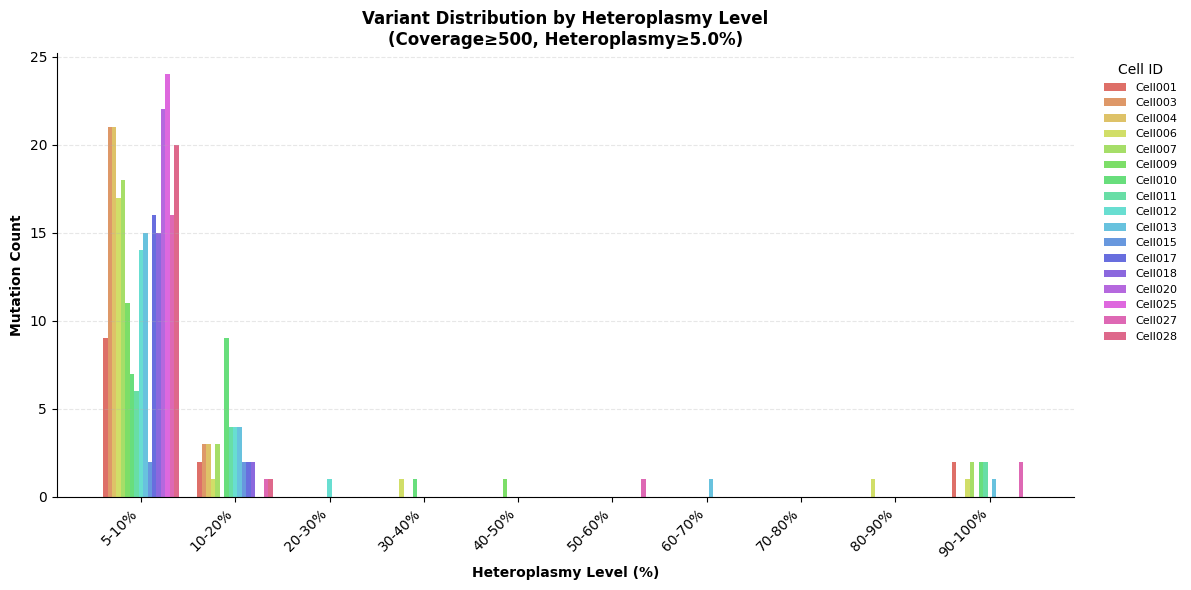

In [9]:
import seaborn as sns

# === Cell 4: Plot 1 — Heteroplasmy Distribution ===

# Define bins directly in plotting code instead of CONFIG
bins = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
bin_labels = [f"{bins[i]}-{bins[i+1]}%" 
              for i in range(len(bins) - 1)]

df_all['het_bin'] = pd.cut(df_all['variant_level'],
                           bins=bins,  # CHANGED: Use 'bins' instead of 'CONFIG['bins']'
                           labels=bin_labels,
                           include_lowest=True)

mutation_counts = df_all.groupby(['cell_id', 'het_bin'], observed=True).size().unstack(fill_value=0)
mutation_counts = mutation_counts.reindex(columns=bin_labels, fill_value=0)
mutation_counts = mutation_counts.reindex(index=all_cells, fill_value=0)

fig, ax = plt.subplots(figsize=(12, 6))
n_cells = len(mutation_counts)
colors = sns.color_palette("hls", n_cells)  # one distinct color per cell

x = np.arange(len(bin_labels))
width = 0.8 / n_cells

for i, cell_id in enumerate(mutation_counts.index):
    offset = (i - n_cells / 2) * width + width / 2
    ax.bar(x + offset, mutation_counts.loc[cell_id], width=width,
           label=cell_id, color=colors[i % len(colors)], alpha=0.9)

ax.set_xlabel('Heteroplasmy Level (%)', fontweight='bold')
ax.set_ylabel('Mutation Count', fontweight='bold')
ax.set_title(f'Variant Distribution by Heteroplasmy Level\n(Coverage≥{CONFIG["min_coverage"]}, Heteroplasmy≥{CONFIG["min_heteroplasmy"]}%)',
             fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(bin_labels, rotation=45, ha='right')
ax.spines[['top', 'right']].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.3)
ax.legend(title='Cell ID', bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False, fontsize=8)
plt.tight_layout()
plt.savefig("variant_distribution.png", dpi=300, bbox_inches='tight')
plt.show()


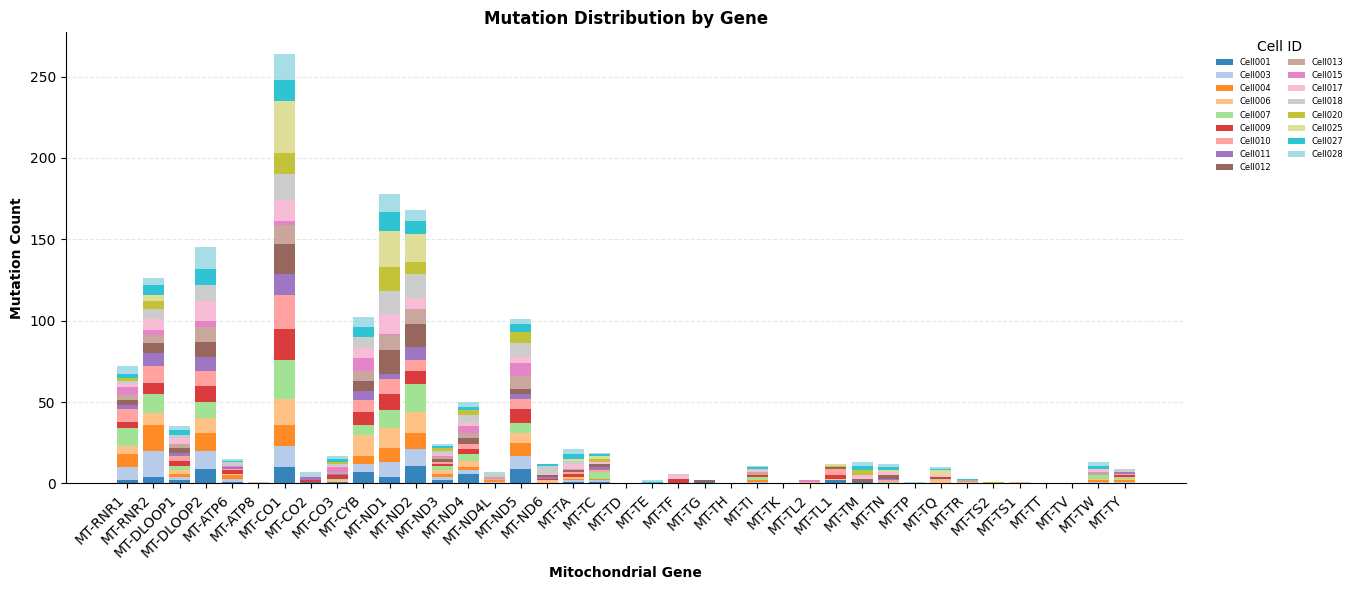

In [18]:
gene_counts = df_all.groupby(['cell_id', 'gene'], observed=True).size().unstack(fill_value=0)

# Hardcoded genomic order
gene_order = [
    'MT-RNR1', 'MT-RNR2', 'MT-DLOOP1', 'MT-DLOOP2', 'MT-ATP6', 'MT-ATP8', 
    'MT-CO1', 'MT-CO2', 'MT-CO3', 'MT-CYB', 'MT-ND1', 'MT-ND2', 'MT-ND3', 
    'MT-ND4', 'MT-ND4L', 'MT-ND5', 'MT-ND6', 'MT-TA', 'MT-TC', 'MT-TD', 
    'MT-TE', 'MT-TF', 'MT-TG', 'MT-TH', 'MT-TI', 'MT-TK', 'MT-TL2', 
    'MT-TL1', 'MT-TM', 'MT-TN', 'MT-TP', 'MT-TQ', 'MT-TR', 'MT-TS2', 
    'MT-TS1', 'MT-TT', 'MT-TV', 'MT-TW', 'MT-TY'
]

# Use reindex to ensure all genes are present, filling missing ones with 0
gene_counts = gene_counts.reindex(columns=gene_order, fill_value=0)

create_stacked_bar(
    gene_counts,
    gene_counts.columns.tolist(),
    f'Mutation Distribution by Gene',
    'Mitochondrial Gene',
    f"variant_distribution_by_gene.png",
    figsize=(max(12, len(gene_counts.columns) * 0.35), 6)
)
plt.show()

In [107]:
print(df_all['gene'].unique())


[nan 'MT-RNR2' 'MT-TL1' 'MT-ND1' 'MT-TM' 'MT-ND2' 'MT-TA' 'MT-TC' 'MT-CO1'
 'MT-CO2' 'MT-CO3' 'MT-TG' 'MT-ND3' 'MT-ND4' 'MT-ND5' 'MT-CYB' 'MT-DLOOP2'
 'MT-RNR1' 'MT-TI' 'MT-TW' 'MT-TY' 'MT-ATP6' 'MT-ND4L' 'MT-TQ' 'MT-TS1'
 'MT-TR' 'MT-TL2' 'MT-ND6' 'MT-TN' 'MT-DLOOP1' 'MT-TF' 'MT-ATP8' 'MT-TS2'
 'MT-TE' 'MT-TP']


In [15]:
# === Cell 7: Display simplified pathogenic variants ===

# Filter for pathogenic variants (MutPred > 0.5)
pathogenic_df = df_all[df_all['MutPred_Score'] > 0.5].copy()

# Build simple columns
pathogenic_df['DNA_change'] = pathogenic_df['Pos'].astype(str) + pathogenic_df['Ref'] + ">" + pathogenic_df['Variant']
pathogenic_df['AA_change'] = pathogenic_df['AminoAcid'].fillna('') + ">" + pathogenic_df['NewAminoAcid'].fillna('')

# Select desired columns
columns_to_show = ['cell_id', 'DNA_change', 'AA_change', 'MutPred_Score', 'OXPHOS_complex']
display_df = pathogenic_df[columns_to_show]

# Output to command line
print(display_df.to_string(index=False))


cell_id DNA_change AA_change  MutPred_Score OXPHOS_complex
Cell001    3394T>C       Y>H          0.783              I
Cell001    3484C>T       P>S          0.665              I
Cell001    3515T>C       L>P          0.738              I
Cell001    4216T>C       Y>H          0.611              I
Cell001    4522T>C       L>P          0.687              I
Cell001    4597T>C       V>A          0.669              I
Cell001    4878G>A       A>T          0.746              I
Cell001    5205T>C       S>P          0.512              I
Cell001    5464T>C       L>P          0.714              I
Cell001    6031A>G       Q>R          0.718             IV
Cell001    6070T>G       V>G          0.622             IV
Cell001    6301C>T       A>V          0.813             IV
Cell001    6325C>T       A>V          0.686             IV
Cell001    6478C>T       A>V          0.748             IV
Cell001    6796A>G       D>G          0.777             IV
Cell001    7691T>C       F>L          0.602             

In [103]:
print(df_all['gene'].unique())



[nan 'MT-RNR2' 'MT-TL1' 'MT-ND1' 'MT-TM' 'MT-ND2' 'MT-TA' 'MT-TC' 'MT-CO1'
 'MT-CO2' 'MT-CO3' 'MT-TG' 'MT-ND3' 'MT-ND4' 'MT-ND5' 'MT-CYB' 'MT-DLOOP2'
 'MT-RNR1' 'MT-TI' 'MT-TW' 'MT-TY' 'MT-ATP6' 'MT-ND4L' 'MT-TQ' 'MT-TS1'
 'MT-TR' 'MT-TL2' 'MT-ND6' 'MT-TN' 'MT-DLOOP1' 'MT-TF' 'MT-ATP8' 'MT-TS2'
 'MT-TE' 'MT-TP']


In [16]:
import pandas as pd

def compare_cell_groups(df_all):
    """Simple comparison between cells 1-20 and cells >20"""
    
    # Get cell numbers
    df_all['cell_num'] = df_all['cell_id'].str.extract('Cell(\d+)').astype(int)
    
    # Split into two groups
    group1 = df_all[df_all['cell_num'] <= 20]
    group2 = df_all[df_all['cell_num'] > 20]
    
    print("=== SIMPLE COMPARISON ===")
    print(f"Cells 1-20: {len(group1)} variants in {group1['cell_id'].nunique()} cells")
    print(f"Cells >20: {len(group2)} variants in {group2['cell_id'].nunique()} cells")
    
    # Basic stats
    print(f"\n--- AVERAGES ---")
    print(f"Variants per cell:")
    print(f"  Cells 1-20: {len(group1)/group1['cell_id'].nunique():.1f}")
    print(f"  Cells >20: {len(group2)/group2['cell_id'].nunique():.1f}")
    
    print(f"\nHeteroplasmy levels:")
    print(f"  Cells 1-20: {group1['variant_level'].mean():.1f}%")
    print(f"  Cells >20: {group2['variant_level'].mean():.1f}%")
    
    # Most common genes
    print(f"\n--- TOP 3 GENES ---")
    for name, group in [('Cells 1-20', group1), ('Cells >20', group2)]:
        top_genes = group['gene'].value_counts().head(3)
        print(f"\n{name}:")
        for gene, count in top_genes.items():
            print(f"  {gene}: {count} variants")
    
    return group1, group2

# Run it
group1, group2 = compare_cell_groups(df_all)

=== SIMPLE COMPARISON ===
Cells 1-20: 1245 variants in 14 cells
Cells >20: 268 variants in 3 cells

--- AVERAGES ---
Variants per cell:
  Cells 1-20: 88.9
  Cells >20: 89.3

Heteroplasmy levels:
  Cells 1-20: 3.9%
  Cells >20: 4.1%

--- TOP 3 GENES ---

Cells 1-20:
  MT-CO1: 203 variants
  MT-ND2: 136 variants
  MT-ND1: 133 variants

Cells >20:
  MT-CO1: 61 variants
  MT-ND1: 45 variants
  MT-ND2: 32 variants


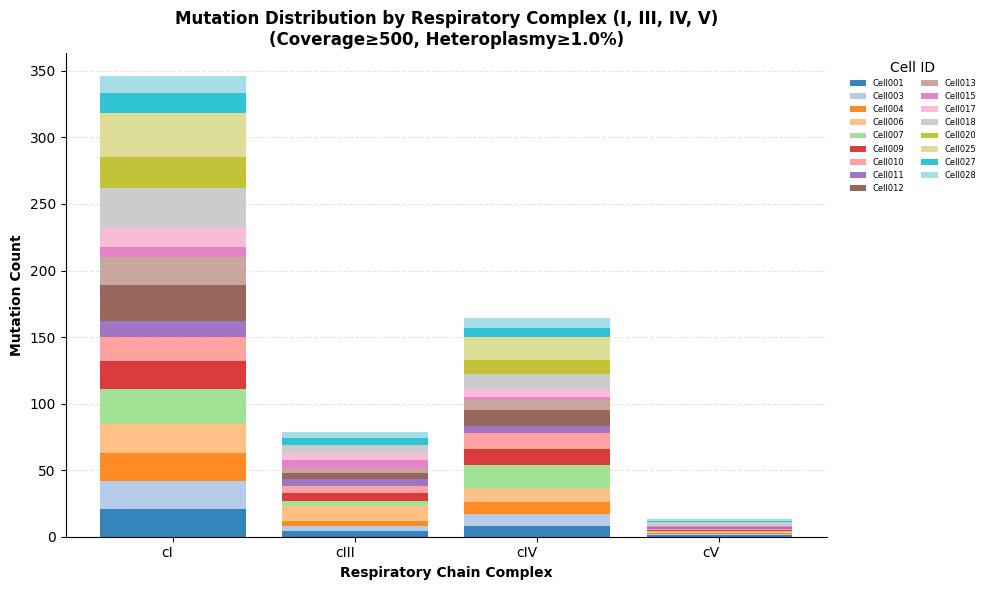

In [17]:
# Filter only variants in OXPHOS complex genes (I, III, IV, V)
df_resp = df_all[df_all['OXPHOS_complex'].notna()].copy()
if df_resp.empty:
    print("⚠️ No variants affecting respiratory complex proteins in filtered data.")
else:
    # Use the OXPHOS_complex column directly
    df_resp['complex'] = df_resp['OXPHOS_complex']
    
    # Standardize complex naming to match your expected format
    complex_mapping = {
        'I': 'cI', 'III': 'cIII', 'IV': 'cIV', 'V': 'cV',
        'CI': 'cI', 'CIII': 'cIII', 'CIV': 'cIV', 'CV': 'cV',
        'Complex I': 'cI', 'Complex III': 'cIII', 'Complex IV': 'cIV', 'Complex V': 'cV'
    }
    df_resp['complex'] = df_resp['complex'].map(complex_mapping).fillna(df_resp['complex'])

    # Group by cell × complex
    complex_counts = df_resp.groupby(['cell_id','complex'], observed=True).size().unstack(fill_value=0)
    complex_counts = complex_counts.reindex(index=all_cells, fill_value=0)

    # Ensure only the relevant complexes are included in the plot
    relevant_complexes = ['cI','cIII','cIV','cV']
    complex_counts = complex_counts.reindex(columns=relevant_complexes, fill_value=0)

    # Plot
    create_stacked_bar(
        complex_counts,
        complex_counts.columns,
        f'Mutation Distribution by Respiratory Complex (I, III, IV, V)\n(Coverage≥{CONFIG["min_coverage"]}, Heteroplasmy≥{CONFIG["min_heteroplasmy"]}%)',
        'Respiratory Chain Complex',
        f"{CONFIG['output_base']}_by_complex.png",
        figsize=(10,6)
    )
    plt.show()

In [ ]:
import random

MTDNA_LENGTH = 16569
N_MUTATIONS = 1000  # number of mutations to simulate

# Each base has an equal chance of mutation
mutations = random.choices(range(1, MTDNA_LENGTH + 1), k=N_MUTATIONS)

print(mutations)

Randomly place N mutations across 16.6kb mtDNA
Count how many fall in each amplicon
Repeat 1,000-10,000 times
Compare observed vs expected



[4351, 11854, 15738, 14053, 15164, 789, 4971, 13481, 588, 15970, 1790, 5681, 12975, 13939, 13930, 4130, 9519, 12448, 11381, 13133, 14462, 7831, 5958, 10006, 801, 10598, 11668, 6403, 6795, 13279, 14126, 1057, 15028, 11555, 8692, 3707, 11478, 3593, 9997, 8320, 8772, 141, 5460, 12956, 10258, 15329, 16081, 7238, 10051, 15588, 7380, 13173, 14071, 4165, 14978, 2257, 4711, 14637, 16127, 10087, 6867, 10543, 10885, 5578, 6368, 5558, 8166, 8925, 10257, 754, 14267, 1486, 2003, 10589, 15440, 218, 6821, 10508, 2430, 904, 1888, 1146, 2571, 4049, 634, 8940, 10031, 13332, 2228, 15691, 5029, 9794, 9239, 15458, 8401, 13897, 15245, 11079, 5423, 4116, 13045, 3173, 9360, 3065, 2007, 15811, 11199, 9822, 3915, 11490, 14021, 15931, 3681, 8607, 5976, 9971, 4310, 12162, 14889, 13879, 9901, 4352, 15163, 15551, 10908, 11727, 11348, 15742, 13382, 11741, 5435, 12585, 5265, 11676, 9321, 14442, 11299, 14381, 14343, 9526, 6403, 15454, 1585, 15480, 1316, 8119, 6814, 16425, 2696, 12847, 14007, 3557, 14389, 8201, 8070, 9